### This notebook includes the use of DeepLabv3+ Network for the MRI brain tumor segmentation problem

### Dataset: 
[https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation]

### The Network is 2D, so volumes of brain was divided into slices, and training and inference was done on slices (not the whole volume at once)

### We worked on t1ce MRI images only due to 2 reasons:
 1. Kaggle's free memory won't fit the whole 4 modalities (t1, t1ce, t2, flair)
 2. The tumor is best clear and evident in t1ce images

#### For each volume, only 83 out of 155 slices were selected.
#### These slices included tumor in the brain while the others had no segmentation (no tumor)

### 2 Trials were made:
 1. A pure implementation from scratch of deeplabv3+ using pytorch
 2. Use a pretrained ready deeplabv3+

# Table of Contents
1. [Import Libraries](#1)
2. [Dataset Preparation](#2)
3. [Trial 1: Implementation from scratch](#3)
4. [Trial 2: Use a pretrained deeplabv3+ model](#4)

<a id='1'><a>
# Import Libraries

In [1]:
pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import nibabel as nib
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.feature_extraction import create_feature_extractor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

<a id='2'><a>
# Dataset Preparation

In [2]:
train_images_paths = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
train_masks_paths = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
train_masks_paths.insert(354,'/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii')

print(len(train_images_paths))
print(len(train_masks_paths))

369
369


In [3]:
x_train, x_test, y_train, y_test = train_test_split(train_images_paths, train_masks_paths, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(len(x_train))
print(len(x_val))
print(len(x_test))

298
34
37


In [5]:
# prepare validation data

val_images = []
val_masks = []

for path_idx in range(30):
    img_path = x_val[path_idx]
    image_t1ce = nib.load(img_path).get_fdata()   # load mri volume
    image_t1ce = image_t1ce/np.max(image_t1ce)    # normalize volume
    image_t1ce = image_t1ce.astype(np.float32)    # convert to float32 to save memory
    image_t1ce= image_t1ce[:, :, 30:113]     # choose 83 slices that contain tumor (rest of slices doesn't contain any tumor)

    mask_path = y_val[path_idx]
    mask = nib.load(mask_path).get_fdata()
    mask[mask==4] = 3          # there is a mistake where the classes labelled as 0,1,2,4...fix this problem
    mask = mask[:, :, 30:113]  # choose 83 slices that contain tumor

    # a backbone resnet is used in deeplabv3+ modeland it takes RGB images as input
    # so, every slice is converted to RGB, and its mask is one hot encoded
    for j in range(83):
        channel = image_t1ce[:,:,j]
        RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)  
        RGB_img = np.moveaxis(RGB_img, -1, 0)
        val_images.append(RGB_img)

        channel = mask[:,:,j]
        channel =  to_categorical(channel, num_classes=4)
        channel = channel.astype(np.float32)
        channel = np.moveaxis(channel, -1, 0)   # pytorch uses channel first convention
        val_masks.append(channel) 

val_images = np.array(val_images)
val_masks = np.array(val_masks)

print(val_images.shape)
print(val_masks.shape)

(2490, 3, 240, 240)
(2490, 4, 240, 240)


<a id='3'><a>
# Trial 1: Implementation from scratch

### The implementation was done according to a keras implementation that can be found in that link: 
[https://keras.io/examples/vision/deeplabv3_plus/#building-the-deeplabv3-model]

### The model didn't work right, there was a problem and after many trials; we stopped working on it due to limited time available (especially that this is the first time we use pytorch instead of tensorflow)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class DeepLabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabv3Plus, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.resnet50 = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=True)
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.resnet50.fc = nn.Identity()
        self.return_nodes = {"layer3.5.relu": "dspp_input", "layer1.2.relu":"decoder_input"}
        self.num_classes = num_classes
        
    def Conv_block(self, Input, num_filters=128, kernel_size=3, dilation_rate=1,padding="same"):
        x = nn.Conv2d(Input.shape[-3], num_filters, kernel_size, padding=padding, dilation=dilation_rate ).to('cuda')(Input)
        x = nn.BatchNorm2d(x.shape[-3]).to('cuda')(x)
        x = nn.ReLU().to('cuda')(x)
        
        return x
    
    def DilatedSpatialPyramidPooling(self, dspp_input):
        dims = dspp_input.shape
        x = nn.AvgPool2d(kernel_size=(dims[-2],dims[-1]))(dspp_input)
        x = self.Conv_block(x, kernel_size=1).to('cuda')
        out_pool = nn.UpsamplingBilinear2d(size=(dims[-2] // x.shape[-2], dims[-1] // x.shape[-1]))(x).to('cuda')
        out_1 = self.Conv_block(dspp_input, kernel_size=1, dilation_rate=1)
        out_6 = self.Conv_block(dspp_input, kernel_size=3, dilation_rate=6)
        out_12 = self.Conv_block(dspp_input, kernel_size=3, dilation_rate=12)
        out_18 = self.Conv_block(dspp_input, kernel_size=3, dilation_rate=18)
        
        x = torch.cat((out_pool, out_1, out_6, out_12, out_18), 1)
        output = self.Conv_block(x, kernel_size=1)
        
        return output
        

    def forward(self, x):
        dims = x.shape
        model2 = create_feature_extractor(self.resnet50, return_nodes=self.return_nodes).to('cuda')
        intermediate_outputs = model2(x.to('cuda'))
        dspp_input = intermediate_outputs["dspp_input"].to('cuda')
        decoder_input = intermediate_outputs["decoder_input"].to('cuda')
        
        dspp_out = self.DilatedSpatialPyramidPooling(dspp_input).to('cuda')
        encoder_out = nn.UpsamplingBilinear2d(scale_factor=(dims[-2] //4// dspp_out.shape[-2], dims[-1] //4// dspp_out.shape[-1]))(dspp_out)
        
        out = self.Conv_block(decoder_input, num_filters=24, kernel_size=1)
        out = torch.cat((encoder_out,out), axis=1)
        out = self.Conv_block(out)
        out = self.Conv_block(out)
        out = nn.UpsamplingBilinear2d(scale_factor=(dims[-2] // out.shape[-2], dims[-1] // out.shape[-1]))(out)
        out = nn.Conv2d(out.shape[1],self.num_classes, kernel_size=1).to('cuda')(out)
        final_out = self.sigmoid(out)
        
        return final_out

<a id='4'><a>
# Trial 2: Use a pretrained model

## It doesn't perform very good as well

In [6]:
model_smp = smp.DeepLabV3Plus('resnet50', classes=4, activation='sigmoid').to('cuda')

In [7]:
loss_fn = smp.losses.DiceLoss(mode='multilabel', from_logits=False)
optimizer = torch.optim.Adam(model_smp.parameters() ,lr=0.001)
steps_per_epoch = 10

In [9]:
# Training and Validation
for epoch in range(2):
    run = 0
    for path_idx in range(len(x_train)):
        s = time.time()
        train_images = []
        train_masks = []

        # same preprocessing for validation data
        img_path = x_train[path_idx]
        image_t1ce = nib.load(img_path).get_fdata()
        image_t1ce = image_t1ce/np.max(image_t1ce)
        image_t1ce = image_t1ce.astype(np.float32)
        image_t1ce= image_t1ce[:, :, 30:113]

        mask_path = y_train[path_idx]
        mask = nib.load(mask_path).get_fdata()
        mask[mask==4] = 3  
        mask = mask[:, :, 30:113]

        for j in range(83):
            channel = image_t1ce[:,:,j]
            RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)
            RGB_img = np.moveaxis(RGB_img, -1, 0)
            train_images.append(RGB_img)

            channel = mask[:,:,j]
            channel =  to_categorical(channel, num_classes=4)
            channel = channel.astype(np.float32)
            channel = np.moveaxis(channel, -1, 0)
            train_masks.append(channel)

        train_images = np.array(train_images)
        train_masks = np.array(train_masks)
        
        dice = 0
        for i in range(0,80,steps_per_epoch):
            print("Steps: ", '-'*(i//10+1), end='\r')
            train_x = train_images[i:i+steps_per_epoch]
            train_y = train_masks[i:i+steps_per_epoch]
            
            # start training
            model_smp.train()
            x = (torch.from_numpy(train_x))
            y = (torch.from_numpy(train_y))
            x = x.to('cuda')
            y = y.to('cuda')

            # Compute prediction error
            pred = model_smp(x)
            loss = loss_fn(y, pred)
            dice += loss.item()
            run += loss.item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        e = time.time()
        print("\nExample: {}, Dice Coeff: {},time: {}".format(path_idx, 1-dice/10,e-s) )
        if path_idx % 20 == 0:
            torch.save(model_smp.state_dict(), "/kaggle/working/Final_deeplab.pth")
    
    # Validation
    model_smp.eval()
    with torch.no_grad():
        val_loss = 0
        running_loss = 0
        for i in range(0,len(val_images),10):
            val_img = val_images[i:i+10]
            val_mask = val_masks[i:i+10]
            x, y = torch.from_numpy(val_img), torch.from_numpy(val_mask)
            x, y = x.to('cuda'), y.to('cuda')
            pred = model_smp(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
            
    running_loss = val_loss/(len(val_images)/10)
    
    print("\nEpoch {}: Dice Coeff: {}, running loss: {},time: {}".format(epoch+1, 1-loss.item(), (run/2980),e-s))
    print("\nValidation: Dice Coeff: {}, running loss: {}".format(1-running_loss, running_loss))

Steps:  --------
Example: 0, Dice Coeff: 0.3538507699966431,time: 5.562533140182495
Steps:  --------
Example: 1, Dice Coeff: 0.38964779973030095,time: 1.6025524139404297
Steps:  --------
Example: 2, Dice Coeff: 0.394646692276001,time: 1.6255683898925781
Steps:  --------
Example: 3, Dice Coeff: 0.4144289672374726,time: 1.5739398002624512
Steps:  --------
Example: 4, Dice Coeff: 0.41248640418052673,time: 1.6669704914093018
Steps:  --------
Example: 5, Dice Coeff: 0.43279083967208865,time: 1.5340330600738525
Steps:  --------
Example: 6, Dice Coeff: 0.42211545705795284,time: 1.5850982666015625
Steps:  --------
Example: 7, Dice Coeff: 0.4510498881340027,time: 1.556037187576294
Steps:  --------
Example: 8, Dice Coeff: 0.42334455251693726,time: 1.5591332912445068
Steps:  --------
Example: 9, Dice Coeff: 0.431095027923584,time: 1.5777151584625244
Steps:  --------
Example: 10, Dice Coeff: 0.45135389566421513,time: 1.597792148590088
Steps:  --------
Example: 11, Dice Coeff: 0.4525754988193512,ti

In [10]:
torch.save(model_smp.state_dict(), "/kaggle/working/Final_deeplab.pth")

## To predict on the test data, kaggle's memory won't fit for all this, so the notebook restarts and i load the saved weights and prepare test data instead of validation data

In [4]:
loss_fn = smp.losses.DiceLoss(mode='multilabel', from_logits=False)
model_loaded = smp.DeepLabV3Plus('resnet50', classes=4, activation='sigmoid')
model_loaded.load_state_dict(torch.load("/kaggle/working/Final_deeplab.pth"))
model_loaded.to('cuda')

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

(3071, 3, 240, 240)
(3071, 4, 240, 240)


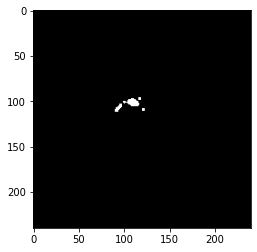

In [5]:
test_images = []
test_masks = []

for path_idx in range(len(x_test)):
    img_path = x_test[path_idx]
    image_t1ce = nib.load(img_path).get_fdata()
    image_t1ce = image_t1ce/np.max(image_t1ce)
    image_t1ce = image_t1ce.astype(np.float32)
    image_t1ce= image_t1ce[:, :, 30:113]

    mask_path = y_test[path_idx]
    mask = nib.load(mask_path).get_fdata()
    mask[mask==4] = 3  
    mask = mask[:, :, 30:113]
    plt.imshow(mask[:,:,78], cmap='gray')
    
    for j in range(83):
        channel = image_t1ce[:,:,j]
        RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)
        RGB_img = np.moveaxis(RGB_img, -1, 0)
        test_images.append(RGB_img)

        channel = mask[:,:,j]
        channel =  to_categorical(channel, num_classes=4)
        channel = channel.astype(np.float32)
        channel = np.moveaxis(channel, -1, 0)
        test_masks.append(channel)

test_images = np.array(test_images)
test_masks = np.array(test_masks)

print(test_images.shape)
print(test_masks.shape)

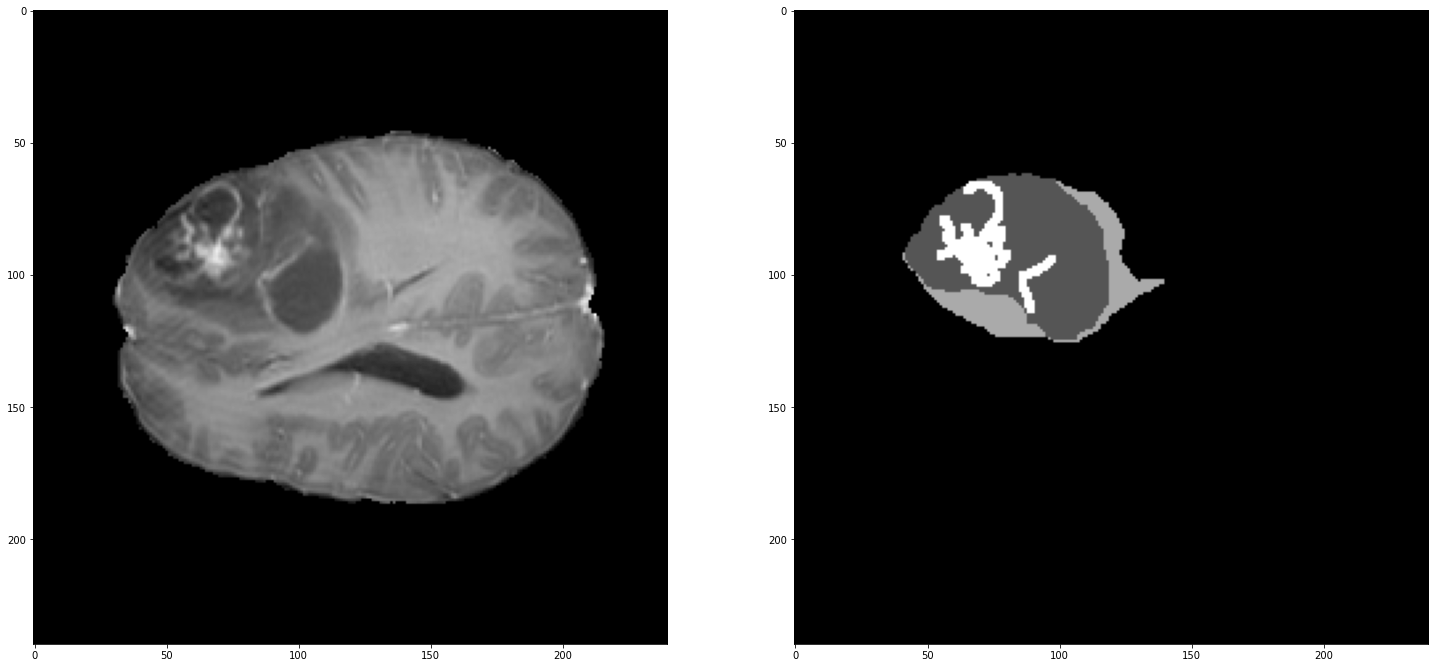

In [12]:
plt.subplot(121)
plt.imshow(test_images[50][0], cmap='gray')

plt.subplot(122)
plt.imshow(np.argmax(test_masks[50],0), cmap='gray')

In [13]:
test = torch.from_numpy(test_images[50:60]).to('cuda')
predictions = model_loaded(test)
predictions.shape

torch.Size([10, 4, 240, 240])

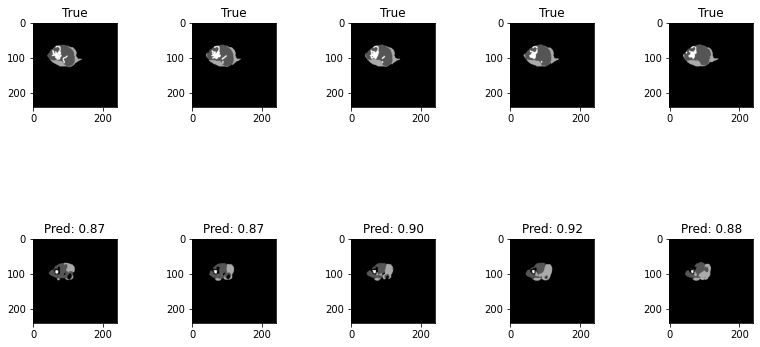

In [14]:
plt.rcParams['figure.figsize']= (25,25)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.5,
                    top=0.3,
                    wspace=0.9,
                    hspace=0.5)

for i in range(5):
    pred = torch.argmax(predictions[i],dim=0)
    true = np.argmax(test_masks[i+50], 0)
    loss = loss_fn(pred, torch.from_numpy(true).to('cuda'))
    dice = 1 - loss.item()
    
    plt.subplot(2,5,i+1)
    plt.imshow(true, cmap='gray')
    plt.title("True")
    
    plt.subplot(2,5,(i+1)+5)
    plt.imshow(pred.cpu(), cmap='gray')
    plt.title("Pred: {:.2f}".format(dice))